<h1> Parameters </h1>

設定変更が必要な項目です。自分の意図した設定になっているか確認してください。

In [1]:
# Global setting
Dict_SetGL = {
    "filname" : "NB0527", # filter 名
    "workdir" : "../Large_files/limit_mag", # 一時ファイルと出力結果の保存先
    "num_seq" : 1,   # 出力ファイル名につく ID, もし別の設定で実行し直す場合に使う
    "lim_sig" : 5.0, # 求めたい限界等級のシグマ
    "imgdir"  : "../Large_files/imgdata", # 画像が配置されている場所
    "maskdir" : "../Large_files/mask_fits" # Mask 画像が配置されている場所
}

# SExtractor
Dict_SetSE = {
    "det_minarea"  : 4,   # DETECT_MINAREA の設定
    "det_thresh"   : 2.0, # DETECT_THRESH の設定
    "ana_thresh"   : 2.0, # ANALYSIS_THRESH の設定
    "back_size"    : 64,  # BACK_SIZE の設定
    "back_filsize" : 3,   # BACK_FILTERSIZE の設定
    "satlev"       : 50000.0, # SATURATION の設定
    "pixscale"     : 0.168,   # Pixel scale の設定
    "num_separam"  : 6    # SExtractor に読み込ませる limit.param に記載したパラメーター数
}

# Random Aperture
Dict_SetRA = {
    "ap_radpix"    : 1.0/0.168,  # ランダムアパーチャー測光をするときの半径 (単位は pixel)
    "inner_widpix" : 3.0,        # スカイ領域として使用する円環の内半径 (単位は pixel, ap_radpix に追加する分の数値を入れる)
    "ann_widpix"   : 1.0/0.168   # スカイ領域として使用する円環の幅 (単位は pixel)
}

# Histogram
Dict_SetHS = {
    "hist_bin" :  0.1,  # ヒストグラムの bin size
    "show_max" :  5.0,  # 図として表示するヒストグラムの範囲（最大値）
    "show_min" : -5.0,  # 図として表示するヒストグラムの範囲（最小値）
    "fit_max"  :  4.0,  # fitting に使用するヒストグラムの範囲（最大値）
    "fit_min"  : -4.0   # fitting に使用するヒストグラムの範囲（最小値）
}

<h1> Modules </h1>

このコードを走らせるために必要なモジュールです。  
ここでエラーが生じる場合は、対応するモジュールが PC にインストールされていません。

In [2]:
import os
import sys
import subprocess
import numpy as np
import scipy.optimize
from decimal import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# astronomical packages
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry

<h1> Functions </h1>

このノートブックを実行するために必要な関数です。  
自作関数を .py ファイルにコピー&保存して import することも可能です。  
どの時点の自作関数を使って計算したのか明確にするため、自分は敢えてノートブックに記載しています。

In [4]:
# inimg            :  input image
# num_hdu          :  HDU number (set HDU number of science frame)
# workdir          :  SExtractor work directory
# img_tmp          :  temporal image file name (with path)
# img_seg          :  segmetation image file name (with path)
# ow_back_size     :  overwrite back_size parameter
# ow_back_filsize  :  overwrite back_filsize parameter
def Lim_RunSExtractor(inimg, num_hdu, workdir, img_tmp, img_seg, **kwargs):

    # SExtractor default setting
    det_minarea = Dict_SetSE['det_minarea']
    det_thresh = Dict_SetSE['det_thresh']
    ana_thresh = Dict_SetSE['ana_thresh']
    back_size = Dict_SetSE['back_size']
    back_filsize = Dict_SetSE['back_filsize']
    satlev = Dict_SetSE['satlev']
    pixscale = Dict_SetSE['pixscale']
    
    # SExtractor がうまく走らない場合があるので、その時に変数を上書きするための設定
    if 'ow_back_size' in kwargs:
        back_size = kwargs['ow_back_size']
    if 'ow_back_filsize' in kwargs:
        back_filsize = kwargs['ow_back_filsize']
    
    # SExtractor file setting
    conf_se = os.path.join(workdir, 'limit.sex')
    param_se = os.path.join(workdir, 'limit.param')
    cat_tmp = os.path.join(workdir, 'limit.cat')
    wei_tmp = os.path.join(workdir, 'limit_wei.fits')
    
    # 指定した hdu の取り出し
    hdu = fits.open(inimg)
    imgd = hdu[num_hdu].data
    hdrd = hdu[num_hdu].header
    hdu.close()
    
    # データ領域の切り取り, single fits 化, rename を行う
    # Mask FITS で edge を定義するようにしているので, 切り取りはもう不要
    fits.writeto(img_tmp, imgd, hdrd, overwrite=True)
    
    
    # Mask 画像を Weight map として利用して SE を走らせる場合の画像を作る
    # Mask は 1:ダメ, 0:OK となっているものを使用しているが SE では逆にする必要があるのでそのように作り替え
    # また, dtype も少なくとも int16 以上が必要なので変更
    if 'img_weimap' in kwargs:
        wei = fits.open(kwargs['img_weimap'])
        weidt = wei[1].data
        weihd = wei[1].header
        wei.close()
        
        fits.writeto(wei_tmp, np.where(weidt > 0, 0, 1).astype('int16'), weihd, overwrite=True)
        
    
    # SExtractor の実行 (Weight map あり)
    if 'img_weimap' in kwargs:
        subprocess.call(["sex", img_tmp,
                         "-c", conf_se,
                         "-CATALOG_NAME", cat_tmp,
                         "-PARAMETERS_NAME", param_se,
                         "-DETECT_MINAREA", str(det_minarea),
                         "-DETECT_THRESH", str(det_thresh),
                         "-ANALYSIS_THRESH", str(ana_thresh),
                         "-SATUR_LEVEL", str(satlev),
                         "-PIXEL_SCALE", str(pixscale),
                         "-BACK_SIZE", str(back_size),
                         "-BACK_FILTERSIZE", str(back_filsize),
                         "-CHECKIMAGE_TYPE", "SEGMENTATION",
                         "-CHECKIMAGE_NAME", img_seg,
                         "-WEIGHT_TYPE", "MAP_WEIGHT",
                         "-WEIGHT_IMAGE", wei_tmp])
        
    # SExtractor の実行 (Weight map なし)
    else:
        subprocess.call(["sex", img_tmp,
                         "-c", conf_se,
                         "-CATALOG_NAME", cat_tmp,
                         "-PARAMETERS_NAME", param_se,
                         "-DETECT_MINAREA", str(det_minarea),
                         "-DETECT_THRESH", str(det_thresh),
                         "-ANALYSIS_THRESH", str(ana_thresh),
                         "-SATUR_LEVEL", str(satlev),
                         "-PIXEL_SCALE", str(pixscale),
                         "-BACK_SIZE", str(back_size),
                         "-BACK_FILTERSIZE", str(back_filsize),
                         "-CHECKIMAGE_TYPE", "SEGMENTATION",
                         "-CHECKIMAGE_NAME", img_seg])
        
    
    # 正しく SExtractor が走ったか確認
    # (行数が Dict_SetSE['num_separaM'] より多いか確認 / 数字は limit.param で与えた数で変わるので注意)
    with open(cat_tmp, mode='r') as f:
        l = f.readlines()
    
    if not os.path.isfile(conf_se) or not os.path.isfile(param_se):
        print( "ERROR : {0} or {1} are not found".format(conf_se, param_se) )
        return -1
    
    elif len(l) <= Dict_SetSE['num_separam']:
        print("CAUTION : SExtractor does not extract any souces")
        return 1
        
    else:
        # print header of SE
        #for i in range(Dict_SetSE['num_separam']):
        #    print( l[i].strip() )
        print( "Total number of detected objects : {0}".format(len(l)) )
        return 0

In [5]:
# img_mask    :  Mask image
# num_mhdu    :  Mask image HDU number
# img_seg     :  SEGMENTATION image
# num_shdu    :  SEGMENTATION image HDU number    
# pix_edge    :  definition for image edge area
# aprad_pix   :  aperture radius in units of pixel
# outreg      :  output region file name
# num_randap  :  Number of random aperture (default = 10000)
# maxiter     :  Maximum iteration for make random aperture (default = 10)
def MkRandomAp(img_mask, num_mhdu, img_seg, num_shdu, pix_edge, aprad_pix, outreg, num_randap=10000, maxiter=10):
    # Aperture Radius for finding sky region (not for photometry)
    laprad_pix = float(aprad_pix) + 1.0
    
    # Load Mask FITS image (select hdu by num_mhdu)
    mhdu = fits.open(img_mask)
    mhdu_img = mhdu[num_mhdu].data
    mhdu_hdr = mhdu[num_mhdu].header
    mhdu.close()
    
    # Load SEGMENTATION FITS image (select hdu by num_shdu)
    shdu = fits.open(img_seg)
    shdu_img = shdu[num_shdu].data
    shdu_hdr = shdu[num_shdu].header
    shdu.close()
    
    # Combine FITS
    masked = mhdu_img + np.where(shdu_img > 0, 1, 0)
    
    # set image area
    img_xsize = mhdu_hdr['NAXIS1']
    img_ysize = mhdu_hdr['NAXIS2']

    
    # Generate random sky aperture (taking account of base difference between image coord and python array)
    # number of sky aperture is 3 X num_randap
    randap_x = np.random.randint(pix_edge*100, (img_xsize-pix_edge)*100, size=num_randap*3)
    randap_y = np.random.randint(pix_edge*100, (img_ysize-pix_edge)*100, size=num_randap*3)
    pos = np.stack([randap_x/100.0-1.0, randap_y/100.0-1.0], 1)
    
    # Measure aperture photometry for mask/segmentation FITS
    apertures = CircularAperture(pos, r=laprad_pix)
    phot_mask = aperture_photometry(masked, apertures)
    pos_sky = pos[np.where(phot_mask['aperture_sum'] < sys.float_info.epsilon)]
    
    
    # Iteration
    i = 0
    while len(pos_sky) <= num_randap:
        randap_x = np.random.randint(pix_edge*100, (img_xsize-pix_edge)*100, size=num_randap*3)
        randap_y = np.random.randint(pix_edge*100, (img_ysize-pix_edge)*100, size=num_randap*3)
        pos = np.stack([randap_x/100.0-1.0, randap_y/100.0-1.0], 1)
        
        apertures = CircularAperture(pos, r=laprad_pix)
        phot_mask = aperture_photometry(masked, apertures)
        
        pos_sky = np.concatenate([ pos_sky, pos[np.where(phot_mask['aperture_sum'] < sys.float_info.epsilon)] ])

        i += 1
        if i > maxiter:
            break

    
    # Prepare data array (taking account of base difference between image coord and python array)
    pos_sky = pos_sky[:num_randap,:] + 1.0
    
    
    # Output Region file
    with open(outreg, mode='w') as f:
        for i in range(num_randap):
            f.write('image;circle({0}, {1}, {2})\n'.format(pos_sky[i][0], pos_sky[i][1], round(aprad_pix, 4)))
            
    # return data array as image coord
    return pos_sky

In [6]:
# inimg      :  Science image
# num_hdu    :  HDU number of input image
# coolis     :  Coord List written as ndarray
# aprad_pix  :  aperture radius in units of pixel
# outfile    :  file name of full output for sky-aperture photometry
# datafile   :  file name of limited output for skyaperture photometry
def AstropyPhot_imgcoo2(inimg, num_hdu, coolis, aprad_pix, outfile, datfile):
    
    # annulus for local sky subtraction
    annin_pix = aprad_pix + Dict_SetRA['inner_widpix']
    annout_pix = aprad_pix + Dict_SetRA['inner_widpix'] + Dict_SetRA['ann_widpix']
    
    # Load Fits image  (select hdu by num_hdu)
    hdu = fits.open(inimg)
    imgd = hdu[num_hdu].data
    hdrd = hdu[num_hdu].header
    hdu.close()
    
    # aperture setting (taking difference of coord difinition into consideration)
    positions = coolis - 1.0
    apertures = CircularAperture(positions, r=aprad_pix)
    annulus_apertures = CircularAnnulus(positions, r_in=annin_pix, r_out=annout_pix)
    
    # run aperture photometry
    phot_table = aperture_photometry(imgd, apertures)
    
    
    # Median / Mean Sky estimation
    # use sigma clipping (3sigma, 10 iteration)
    # arguments of sigma clip function may change depending on astropy version
    annulus_masks = annulus_apertures.to_mask(method='center')
    bkg_median = []
    bkg_mean = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(imgd)
        annulus_data_1d = annulus_data[mask.data > 0]
        #mean_sigclip, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.0, iters=10)
        mean_sigclip, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.0, maxiters=10)
        bkg_median.append(median_sigclip)
        bkg_mean.append(mean_sigclip)
        
    bkg_median = np.array(bkg_median)
    bkg_mean = np.array(bkg_mean)
    
    
    # calculate median_sky / mean_sky subtracted flux, and store the information
    phot_table['annulus_med'] = bkg_median
    #phot_table['aper_medbkg'] = bkg_median * apertures.area()
    phot_table['aper_medbkg'] = bkg_median * apertures.area
    phot_table['aper_medbkgsub'] = phot_table['aperture_sum'] - phot_table['aper_medbkg']

    phot_table['annulus_ave'] = bkg_mean
    #phot_table['aper_avebkg'] = bkg_mean * apertures.area()
    phot_table['aper_avebkg'] = bkg_mean * apertures.area
    phot_table['aper_avebkgsub'] = phot_table['aperture_sum'] - phot_table['aper_avebkg']
    
    
    # convert magnitude
    phot_table['aper_mag'] = np.where(phot_table['aperture_sum'] > 0, 27.0 - 2.5 * np.log10(phot_table['aperture_sum']), -99.0)
    phot_table['aper_medbkgsub_mag'] = np.where(phot_table['aper_medbkgsub'] > 0, 27.0 - 2.5 * np.log10(phot_table['aper_medbkgsub']), -99.0)
    phot_table['aper_avebkgsub_mag'] = np.where(phot_table['aper_avebkgsub'] > 0, 27.0 - 2.5 * np.log10(phot_table['aper_avebkgsub']), -99.0)
    
    
    # print detailed results (aperture_photometry class is similar to astropy Table class)
    phot_table.write(outfile, format='ascii.commented_header',
                     formats={'aperture_sum': '%.8f',
                              'annulus_med': '%.8f', 'aper_medbkg': '%.8f', 'aper_medbkgsub': '%.8f',
                              'annulus_ave': '%.8f', 'aper_avebkg': '%.8f', 'aper_avebkgsub': '%.8f',
                              'aper_mag': '%8.4f', 'aper_medbkgsub_mag': '%8.4f', 'aper_avebkgsub_mag': '%8.4f'},
                     overwrite=True)
    
    # print selected results
    phot_table.write(datfile, format='ascii.no_header',
                     formats={'aperture_sum': '%.8f', 'aper_medbkgsub': '%.8f', 'aper_avebkgsub': '%.8f'},
                     include_names=['aperture_sum', 'aper_medbkgsub', 'aper_avebkgsub'],
                     overwrite=True)

In [7]:
# ラフなチェック用
def Lim_PltHist2(subfile, xmin, xmax, binsize):
    
    # load data
    data = np.loadtxt(subfile)
    data1 = data[:,0]  ## Original count
    data2 = data[:,1]  ## Median Sky subtracted count
    data3 = data[:,2]  ## Mean Sky subtracted count
    
    # histogram setting (bin 数は round で計算する)
    nx = round((xmax - xmin) / binsize)
    
    # データのプロット (figure オブジェクトの用意)
    fig = plt.figure(figsize=(10,4))
    
    # ax1 : Original count
    # ax2 : Median Sky subtracted count
    # ax3 : Mean Sky subtracted count
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    ax1.hist(data1, bins=nx, range=(xmin,xmax))
    ax1.set_xlim(xmin,xmax)
    ax1.set_title("Original count")
    ax1.set_xlabel('Count', fontsize=20)
    ax1.set_ylabel('Number', fontsize=20)

    ax2.hist(data2, bins=nx, range=(xmin,xmax))
    ax2.set_xlim(xmin,xmax)
    ax2.set_title("Median Sky-Subtracted count")
    ax2.set_xlabel('Count', fontsize=20)
    ax2.set_ylabel('Number', fontsize=20)

    ax3.hist(data3, bins=nx, range=(xmin,xmax))
    ax3.set_xlim(xmin,xmax)
    ax3.set_title("Mean Sky-Subtracted count")
    ax3.set_xlabel('Count', fontsize=20)
    ax3.set_ylabel('Number', fontsize=20)
    
    fig.tight_layout()

    plt.show()
    plt.close()

In [8]:
## Gaussian Fitting,  amplitude/mean/sigma is Free parameter
## baseline is fixed ( baseline = 0 )
## Using scipy.optimize.curve_fit, NOT taking uncertainty in Y-axis into consideration
# data       : 1-D numpy array, fitting data
# xmin       : minimum of histgram
# xmax       : maximum of histgram
# xbin       : bin width of histgram
# init_mean  : initial condition of mean
# init_sigma : initial condition of sigma
# titlename  : Title of figure
# filename   : output file name
def HistgramGaussianFit(data, xmin, xmax, xbin, xclip_low, xclip_high, titlename, outfig):
    
    # Gaussian function
    def gaussian_ams(x, A, mean, sigma):
        gauss = A * np.exp(-(x-mean)**2.0/(2.0*pow(sigma, 2.0)))
        return(gauss)

    # make histgram for 1-D data
    data_hist = plt.hist(data, bins=np.arange(xmin, xmax, xbin), align='mid')
    x_hist = data_hist[1]
    y_count = data_hist[0]
    
    
    # Fitting range を指定 (xclip で上限と下限を与える)
    # xmin/xmax と xclip_low/xclip_high が同じ数字だと np.where のところで配列がズレてしまうので修正
    # y_count から始める (or 別名にする) しないと x_hist が更新されるため適切に配列が選べなくなるので注意
    y_count_trim = y_count[np.where((x_hist > xclip_low-xbin) & (x_hist < xclip_high+xbin) )]    
    x_hist_trim = x_hist[np.where((x_hist > xclip_low-xbin) & (x_hist < xclip_high+xbin) )]

    
    # make xbin for fitting ( histgram xbin is not sutable for fitting )
    # also make y_xcenter (このままだと y_count の方が 1 列多くなってしまうため)
    x_center = np.array([])
    y_xcenter = np.array([])
    for i in range(len(x_hist_trim)-1):
        x_center = np.append(x_center, np.array((x_hist_trim[i] + x_hist_trim[i+1]) / 2.0))
        y_xcenter = np.append(y_xcenter, y_count_trim[i])
    
    # Fitting
    Amp = np.max(y_xcenter)
    mean = np.mean(data)
    sigma = np.std(data)
    param0 = [Amp, mean, sigma]
    param_bounds = ((-np.inf, -np.inf, 0.0), (np.inf, np.inf, np.inf))
    
    param_opt, param_cov = scipy.optimize.curve_fit(gaussian_ams, x_center, y_xcenter, p0=param0, absolute_sigma=False, bounds=param_bounds)
    param_err = np.sqrt(np.diag(param_cov))
    
    # display the results
    print("Fitting Result for %s \n" % titlename)
    print("  Fitting range  [ %9.3f  - %9.3f  ]" % (xclip_low, xclip_high))
    print("  Number of bins   %4d \n" % len(x_center))
    
    print("  Amplitude   : %12.5f   +/- %12.5f"    % (param_opt[0], param_err[0]))
    print("  Center      : %12.5f   +/- %12.5f"    % (param_opt[1], param_err[1]))
    print("  Sigma       : %12.5f   +/- %12.5f \n" % (param_opt[2], param_err[2]))
    
    # plot results
    x_gss = np.arange(xmin, xmax, xbin/10.0)
    plt.plot(x_gss, gaussian_ams(x_gss, param_opt[0], param_opt[1], param_opt[2]))
    plt.axvline(x=param_opt[1], color='red', ls='dotted', lw=1.5)
    plt.xlabel('Count')
    plt.ylabel('Number')

    plt.title(titlename)
    plt.text(param_opt[1]-1.0*param_opt[2], param_opt[0], 'Mean = %.5f' % param_opt[1],
             horizontalalignment='right', verticalalignment='center')
    plt.text(param_opt[1]+1.0*param_opt[2], param_opt[0], 'Sigma = %.5f' % param_opt[2],
             horizontalalignment='left', verticalalignment='center')

    plt.savefig(outfig, dpi=150)
    #plt.show()
    plt.close()
    
    # return the fitting results
    return param_opt, param_err

In [9]:
def Lim_PrintRes(subfile, xmin, xmax, xbin, name_outfig,
                 xclip_low_org, xclip_high_org, xclip_low_med, xclip_high_med, xclip_low_ave, xclip_high_ave,
                 outtxt, aprad_pix, limsig=5.0):
    
    # load data
    data = np.loadtxt(subfile)
    
    # Originl count result
    outfig = name_outfig + 'org.png'
    cntorg = data[:,0]
    org_opt, org_err = HistgramGaussianFit(cntorg, xmin, xmax, xbin, xclip_low_org, xclip_high_org, 'Original Count', outfig)
    
    # Median Sky-Subtracted count result
    outfig = name_outfig + 'med.png'
    cntorg = data[:,1]
    med_opt, med_err = HistgramGaussianFit(cntorg, xmin, xmax, xbin, xclip_low_med, xclip_high_med, 'Med-Sky Sub Count', outfig)

    # Mean Sky-Subtracted count result
    outfig = name_outfig + 'ave.png'
    cntorg = data[:,2]
    ave_opt, ave_err = HistgramGaussianFit(cntorg, xmin, xmax, xbin, xclip_low_ave, xclip_high_ave, 'Ave-Sky Sub Count', outfig)
    
    print( "{} sigma Lim. Mag  (Original)     :  {:.6}".format(limsig, 27.0 - 2.5 * np.log10(org_opt[2]*limsig)) )
    print( "{} sigma Lim. Mag  (Med-Sky Sub)  :  {:.6}".format(limsig, 27.0 - 2.5 * np.log10(med_opt[2]*limsig)) )
    print( "{} sigma Lim. Mag  (Ave-Sky Sub)  :  {:.6}".format(limsig, 27.0 - 2.5 * np.log10(ave_opt[2]*limsig)) )
    
    # 数値をファイルに出力
    with open(outtxt, mode='w') as f:
        f.write( "# Aperture Size  :  {:.6}\n".format(aprad_pix) )
        f.write( "  Original count\n" )
        f.write( "     -->> Clipping range       :  {:.3} ... {:.3}\n".format(xclip_low_org, xclip_high_org))
        f.write( "     -->> {} sigma_Lim._Mag   :  {:.6}\n".format(limsig, 27.0 - 2.5 * np.log10(org_opt[2]*limsig)) )
        f.write( "  Med-Sky Sub count\n" )
        f.write( "     -->> Clipping range       :  {:.3} ... {:.3}\n".format(xclip_low_med, xclip_high_med))
        f.write( "     -->> {} sigma_Lim._Mag   :  {:.6}\n".format(limsig, 27.0 - 2.5 * np.log10(med_opt[2]*limsig)) )
        f.write( "  Ave-Sky Sub count\n" )
        f.write( "     -->> Clipping range       :  {:.3} ... {:.3}\n".format(xclip_low_ave, xclip_high_ave))
        f.write( "     -->> {} sigma_Lim._Mag   :  {:.6}\n".format(limsig, 27.0 - 2.5 * np.log10(ave_opt[2]*limsig)) )

<h1> Operation Command </h1>

限界等級を計算するためのマクロです。上記関数をこのマクロ関数で呼び出して実行します。  
MacroLM_hsc は HSC の画像に対して実行することを念頭においたマクロになっています。  
HSC 以外の画像について実行する場合は、MacroLM_others を使用してください。

どちらの場合にも、calexp 変数と combmask 変数のファイル名はチェックしてください。  
calexp がサイエンス画像、combmask がマスク画像の名前になっている必要があります。

In [10]:
## tract : tract number
## px    : patch_x number, ex. if patch=(2,4), set 2
## py    : patch_y number, ex. if patch=(2,4), set 4
## nap   : number of aperture (測定に使うアパーチャーの数)
## nit   : number of iteration (天体をよけてアパーチャーを用意するときの for 文の繰り返し回数)
##       : 補足 天体が混んでいる画像だったり, SE が上手く走らなかった時に適当に止めるため与えている
def MacroLM_hsc( tract, px, py, nap, nit ):
    # print current patch
    print("\n ===============================================")
    print(" -->> Start estimating Lim-Mag for Patch : {0},{1}".format(px, py))
    print(" ===============================================\n")
    
    # general setting
    filname   = Dict_SetGL['filname']
    ap_radpix = Dict_SetRA['ap_radpix']
    num_seq   = Dict_SetGL['num_seq']
    
    DIR_img  = Dict_SetGL['imgdir']
    DIR_mask = Dict_SetGL['maskdir']
    DIR_work = Dict_SetGL['workdir']

    img_tmp  = os.path.join( DIR_work, 'limit_tmp.fits' )
    img_seg  = os.path.join( DIR_work, 'limit_seg.fits' )
    
    # input image setting (自分の用意したファイル名と一致するかチェック!!)
    calexp   = os.path.join( DIR_img, 'calexp-{0}-{1}-{2},{3}.fits'.format(filname, tract, px, py) )
    combmask = os.path.join( DIR_mask, 'CombMask_{0}_t{1}p{2}0{3}.fits'.format(filname, tract, px, py) )
    
    # output setting
    skyreg      = os.path.join( DIR_work, 'skylis_{0}_t{1}p{2}0{3}.{4}.reg'.format(filname, tract, px, py, num_seq) )
    phot_detail = os.path.join( DIR_work, 'astrphot_{0}_t{1}p{2}0{3}.{4}.txt'.format(filname, tract, px, py, num_seq) )
    phot_sub    = os.path.join( DIR_work, 'astrphot_{0}_t{1}p{2}0{3}.{4}sub.dat'.format(filname, tract, px, py, num_seq) )
    name_outfig = os.path.join( DIR_work, 'resfit_{0}_t{1}p{2}0{3}.{4}'.format(filname, tract, px, py, num_seq) )
    res_lim     = os.path.join( DIR_work, 'res_limmag_{0}_t{1}p{2}0{3}.{4}.txt'.format(filname, tract, px, py, num_seq) )
    

    # print setting
    print( "Aperuture Radius [pix] : {0:.4f}".format(ap_radpix) )
    
    
    # check data/directory & Run SExtractor
    if not os.path.isdir(DIR_work):
        print( "ERROR : Work directory is not found. Check path {0}".format(DIR_work) )
        flg_runse = -1
        
    elif not os.path.isfile(calexp):
        print( "ERROR : Image file is not found. Check path {0}".format(calexp) )
        flg_runse = -1
        
    elif os.path.isfile(combmask):
        flg_runse = Lim_RunSExtractor( calexp, 1, DIR_work, img_tmp, img_seg, img_weimap=combmask )
    
    else:
        print("Notice : Mask file is not found, SE is operated without mask image")
        flg_runse = Lim_RunSExtractor( calexp, 1, DIR_work, img_tmp, img_seg )

        
    # conduct random aperture photometry
    if flg_runse == 0:
        # Make Random Aperture / Measure Aperture photometry
        sky_pos = MkRandomAp( combmask, 1, img_seg, 0, 100, ap_radpix, skyreg, num_randap=nap, maxiter=nit )
        AstropyPhot_imgcoo2( img_tmp, 0, sky_pos, ap_radpix, phot_detail, phot_sub )
        
        # Check Histogram and Fitting 
        Lim_PltHist2( phot_sub, Dict_SetHS['fit_min'], Dict_SetHS['fit_max'], Dict_SetHS['hist_bin'] )
        
        Lim_PrintRes( phot_sub, Dict_SetHS['show_min'], Dict_SetHS['show_max'], Dict_SetHS['hist_bin'],
                      name_outfig,
                      Dict_SetHS['fit_min'], Dict_SetHS['fit_max'],
                      Dict_SetHS['fit_min'], Dict_SetHS['fit_max'],
                      Dict_SetHS['fit_min'], Dict_SetHS['fit_max'],
                      res_lim, ap_radpix, limsig=Dict_SetGL['lim_sig'] )
    
    else:
        print( "patch {0}0{1} is failed".format(px, py) )

In [11]:
## nap   : number of aperture (測定に使うアパーチャーの数)
## nit   : number of iteration (天体をよけてアパーチャーを用意するときの for 文の繰り返し回数)
##       : 補足 天体が混んでいる画像だったり, SE が上手く走らなかった時に適当に止めるため与えている
def MacroLM_others( nap, nit ):
    # print current patch
    print("\n ===============================================")
    print(" -->> Start estimating Lim-Mag ")
    print(" ===============================================\n")
    
    # general setting
    filname   = Dict_SetGL['filname']
    ap_radpix = Dict_SetRA['ap_radpix']
    num_seq   = Dict_SetGL['num_seq']
    
    DIR_img  = Dict_SetGL['imgdir']
    DIR_mask = Dict_SetGL['maskdir']
    DIR_work = Dict_SetGL['workdir']

    img_tmp  = os.path.join( DIR_work, 'limit_tmp.fits' )
    img_seg  = os.path.join( DIR_work, 'limit_seg.fits' )
    
    # input image setting (自分の用意したファイル名と一致するかチェック!!)
    calexp   = os.path.join( DIR_img, 'calexp-NB0527-9813-4,4.fits' )
    combmask = os.path.join( DIR_mask, 'CombMask_NB0527_t9813p404.fits' )
    
    # output setting
    skyreg      = os.path.join( DIR_work, 'skylis_image.{0}.reg'.format(num_seq) )
    phot_detail = os.path.join( DIR_work, 'astrphot_image.{0}.txt'.format(num_seq) )
    phot_sub    = os.path.join( DIR_work, 'astrphot_image.{0}sub.dat'.format(num_seq) )
    name_outfig = os.path.join( DIR_work, 'resfit_image.{0}'.format(num_seq) )
    res_lim     = os.path.join( DIR_work, 'res_limmag_image.{0}.txt'.format(num_seq) )
    

    # print setting
    print( "Aperuture Radius [pix] : {0:.4f}".format(ap_radpix) )
    
    
    # check data/directory & Run SExtractor
    if not os.path.isdir(DIR_work):
        print( "ERROR : Work directory is not found. Check path {0}".format(DIR_work) )
        flg_runse = -1
        
    elif not os.path.isfile(calexp):
        print( "ERROR : Image file is not found. Check path {0}".format(calexp) )
        flg_runse = -1
        
    elif os.path.isfile(combmask):
        flg_runse = Lim_RunSExtractor( calexp, 1, DIR_work, img_tmp, img_seg, img_weimap=combmask )
    
    else:
        print("Notice : Mask file is not found, SE is operated without mask image")
        flg_runse = Lim_RunSExtractor( calexp, 1, DIR_work, img_tmp, img_seg )

        
    # conduct random aperture photometry
    if flg_runse == 0:
        # Make Random Aperture / Measure Aperture photometry
        sky_pos = MkRandomAp( combmask, 1, img_seg, 0, 100, ap_radpix, skyreg, num_randap=nap, maxiter=nit )
        AstropyPhot_imgcoo2( img_tmp, 0, sky_pos, ap_radpix, phot_detail, phot_sub )
        
        # Check Histogram and Fitting 
        Lim_PltHist2( phot_sub, Dict_SetHS['fit_min'], Dict_SetHS['fit_max'], Dict_SetHS['hist_bin'] )
        
        Lim_PrintRes( phot_sub, Dict_SetHS['show_min'], Dict_SetHS['show_max'], Dict_SetHS['hist_bin'],
                      name_outfig,
                      Dict_SetHS['fit_min'], Dict_SetHS['fit_max'],
                      Dict_SetHS['fit_min'], Dict_SetHS['fit_max'],
                      Dict_SetHS['fit_min'], Dict_SetHS['fit_max'],
                      res_lim, ap_radpix, limsig=Dict_SetGL['lim_sig'] )
    
    else:
        print( "patch {0}0{1} is failed".format(px, py) )

<h2> Test </h2>


 -->> Start estimating Lim-Mag for Patch : 4,4

Aperuture Radius [pix] : 5.9524
Total number of detected objects : 14733


/home/syamanaka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10
/home/syamanaka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
/home/syamanaka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log10


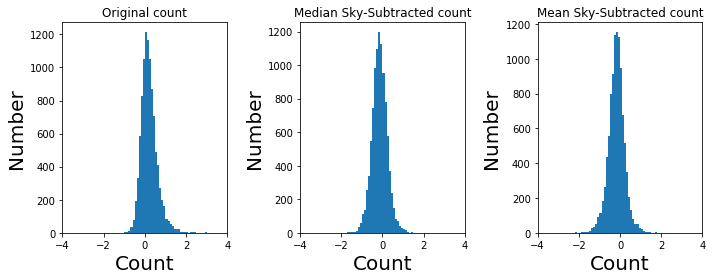

Fitting Result for Original Count 

  Fitting range  [    -4.000  -     4.000  ]
  Number of bins     81 

  Amplitude   :   1166.19585   +/-     15.50887
  Center      :      0.13498   +/-      0.00507
  Sigma       :      0.32985   +/-      0.00507 

Fitting Result for Med-Sky Sub Count 

  Fitting range  [    -4.000  -     4.000  ]
  Number of bins     81 

  Amplitude   :   1161.80841   +/-      6.47087
  Center      :     -0.14582   +/-      0.00215
  Sigma       :      0.33487   +/-      0.00215 

Fitting Result for Ave-Sky Sub Count 

  Fitting range  [    -4.000  -     4.000  ]
  Number of bins     81 

  Amplitude   :   1138.40381   +/-      9.12425
  Center      :     -0.16651   +/-      0.00314
  Sigma       :      0.33908   +/-      0.00314 

5.0 sigma Lim. Mag  (Original)     :  26.4568
5.0 sigma Lim. Mag  (Med-Sky Sub)  :  26.4404
5.0 sigma Lim. Mag  (Ave-Sky Sub)  :  26.4268


In [12]:
# test run
MacroLM_hsc(9813, 4, 4, 10000, 10)


 -->> Start estimating Lim-Mag 

Aperuture Radius [pix] : 5.9524
Total number of detected objects : 14733


/home/syamanaka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log10
/home/syamanaka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
/home/syamanaka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log10


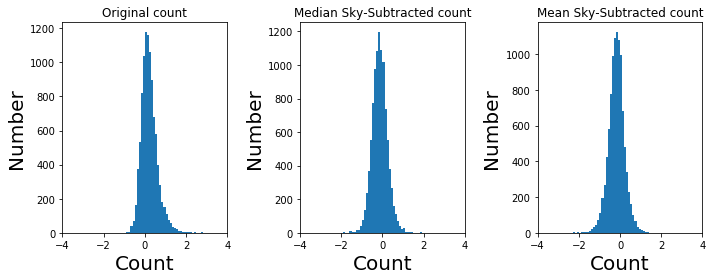

Fitting Result for Original Count 

  Fitting range  [    -4.000  -     4.000  ]
  Number of bins     81 

  Amplitude   :   1157.76849   +/-     14.54403
  Center      :      0.14455   +/-      0.00484
  Sigma       :      0.33373   +/-      0.00484 

Fitting Result for Med-Sky Sub Count 

  Fitting range  [    -4.000  -     4.000  ]
  Number of bins     81 

  Amplitude   :   1155.43777   +/-      6.71839
  Center      :     -0.14739   +/-      0.00227
  Sigma       :      0.33819   +/-      0.00227 

Fitting Result for Ave-Sky Sub Count 

  Fitting range  [    -4.000  -     4.000  ]
  Number of bins     81 

  Amplitude   :   1126.28395   +/-      8.60365
  Center      :     -0.16853   +/-      0.00303
  Sigma       :      0.34400   +/-      0.00303 

5.0 sigma Lim. Mag  (Original)     :  26.4441
5.0 sigma Lim. Mag  (Med-Sky Sub)  :  26.4297
5.0 sigma Lim. Mag  (Ave-Sky Sub)  :  26.4112


In [13]:
# test run
MacroLM_others(10000, 10)

現在のバージョンだと、`RuntimeWarning: invalid value encountered in log10` という警告が出てしまいます。  
これは log10 関数の仕様のようで、np.where の中で使うと実際には log10 の中に変な数字が入るはずがなくても出てしまいます。  
今のところは対処できていると思っているのでそのままですが、いずれ直したいと思っています。

<h1> Run </h1>

HSC で観測された撮像データに一括で実行する場合の一例。

<h3> Patch = 2,4 - 8,4 </h3>

<table>
    <tr><td>0,8</td><td>1,8</td><td>2,8</td><td>3,8</td><td>4,8</td><td>5,8</td><td>6,8</td><td>7,8</td><td>8,8</td></tr>
    <tr><td>0,7</td><td>1,7</td><td>2,7</td><td>3,7</td><td>4,7</td><td>5,7</td><td>6,7</td><td>7,7</td><td>8,7</td></tr>
    <tr><td>0,6</td><td>1,6</td><td>2,6</td><td>3,6</td><td>4,6</td><td>5,6</td><td>6,6</td><td>7,6</td><td>8,6</td></tr>
    <tr><td>0,5</td><td>1,5</td><td>2,5</td><td>3,5</td><td>4,5</td><td>5,5</td><td>6,5</td><td>7,5</td><td>8,5</td></tr>
    <tr><td>0,4</td><td>1,4</td><td bgcolor="cyan">2,4</td><td bgcolor="cyan">3,4</td><td bgcolor="cyan">4,4</td><td bgcolor="cyan">5,4</td><td bgcolor="cyan">6,4</td><td bgcolor="cyan">7,4</td><td bgcolor="cyan">8,4</td></tr>
    <tr><td>0,3</td><td>1,3</td><td>2,3</td><td>3,3</td><td>4,3</td><td>5,3</td><td>6,3</td><td>7,3</td><td>8,3</td></tr>
    <tr><td>0,2</td><td>1,2</td><td>2,2</td><td>3,2</td><td>4,2</td><td>5,2</td><td>6,2</td><td>7,2</td><td>8,2</td></tr>
    <tr><td>0,1</td><td>1,1</td><td>2,1</td><td>3,1</td><td>4,1</td><td>5,1</td><td>6,1</td><td>7,1</td><td>8,1</td></tr>
    <tr><td>0,0</td><td>1,0</td><td>2,0</td><td>3,0</td><td>4,0</td><td>5,0</td><td>6,0</td><td>7,0</td><td>8,0</td></tr>
</table>

In [ ]:
#for x in range(2, 9, 1):
#    MacroLM(9813, x, 4, 10000, 10)

実行するとノートブックのサイズが大きくなりすぎてしまうので、コメントアウトしています。  
ファイルを適切に配置すれば実行できるはずです。